In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## define PSF

In [2]:
def R_lambda(q_obs, q_mod, lambda_ratio_list, w_lambda, mu_q):
    r"""
    Constructs the full polychromatic point-spread function R(q, q') such that

        I_obs(q) = ∫ R(q, q') I_mod(q') dq'  ≈  (R @ I_mod)(q)

    Parameters
    ----------
    q_obs : (M_obs,) ndarray
        Q-values where the observed intensity I_obs(q) is evaluated.
    q_mod : (M_mod,) ndarray
        Q'-values defining the latent/model intensity I_mod(q').
    lambda_ratio_list : (N,) ndarray
        Ratios ρ_i = λ_i / λ_0 for each wavelength component.
    w_lambda : (N,) ndarray
        Normalized spectral weights (∑ w_lambda = 1).
    mu_q : float
        Gaussian width (in Q-units) controlling the mapping spread from q_mod → q_obs.

        - Small mu_q  → narrow PSF, nearly δ(q−ρq′)
        - Large mu_q  → broad smearing, stronger convolution

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel approximating R(q, q') including wavelength distribution.

    Notes
    -----
    Implements:
        R(q,q') = Σ_i w_i · [ exp(−(q − ρ_i q')² / (2 μ_q²)) / Z_i(q') ]
    where Z_i(q') ensures ∫ R(q,q') dq = 1 for each q'.

    --------------------------------------------------------------------------
    LaTeX source 
    --------------------------------------------------------------------------
    \begin{equation}
        R(q,q')
        \;=\;
        \sum_{i} w_i \,
        \frac{
            \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        }{
            Z_i(q')
        },
        \qquad
        Z_i(q')
        \;=\;
        \int_{-\infty}^{\infty}
        \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        \mathrm{d}q.
        \label{eq:R_q_def}
    \end{equation}
    --------------------------------------------------------------------------
    """
    q_obs = np.asarray(q_obs)
    q_mod = np.asarray(q_mod)
    lambda_ratio_list = np.asarray(lambda_ratio_list)
    w_lambda = np.asarray(w_lambda)

    M_obs, M_mod = q_obs.size, q_mod.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # --- Implements: R(q, q') = Σ_i w_i * exp[-(q - ρ_i q')² / (2 μ_q²)] / Z_i(q') ---
    for rho, w_i in zip(lambda_ratio_list, w_lambda):
        q_center = rho * q_mod[None, :]           # Shift q' → ρ_i q'
        diff = q_obs[:, None] - q_center          # (M_obs, M_mod)
        phi = np.exp(-0.5 * (diff / mu_q) ** 2)

        # Normalize over q_obs for each q' (column-wise)
        Z_i = phi.sum(axis=0, keepdims=True)
        Z_i[Z_i == 0] = 1.0
        phi /= Z_i

        # Weighted sum over wavelength components
        R += w_i * phi

    return R

In [3]:
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R


## test smearing a given function

In [4]:
def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

def P_ts(Q, q_max, c):
    Qq = Q/q_max
    P = 1/((1-c)*((1-Qq**2)**2)+c)
    P[Qq==0] = 1
    return P

from scipy.special import sici as sici
def S_rod(q,L):
    y = 2*sici(q*L)[0]/(q*L) - 4*np.sin(q*L/2)**2/(q*L)**2

    return y  

/tmp/ipykernel_1031610/534361509.py:111: RuntimeWarning: invalid value encountered in sqrt
  I_post_std = np.sqrt(np.diag(Cov_f))


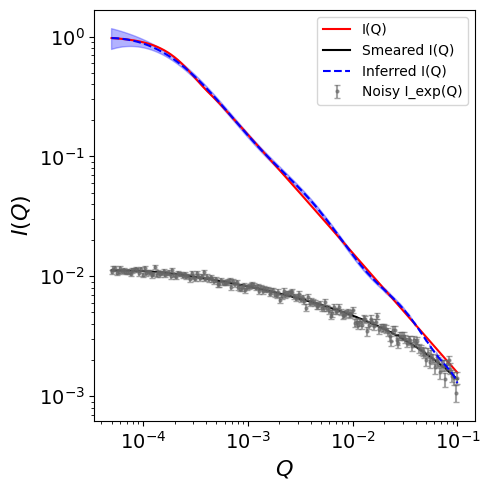

In [68]:
# f_Q = lambda Q: P_hs(Q) + 0.001
# f_Q = lambda Q: P_ts(Q, 10, 0.5) + 0.001
f_Q = lambda Q: S_rod(Q, 2e4)

f_R = lambda Q1, Q2: R_slit(Q1, Q2, sigma_y=0.1)
# f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-7, sigma_y=5, nx=256, quad='gauss')

Q_min = 5e-5
Q_max = 0.1
# Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_sampled = np.logspace(np.log10(Q_min), np.log10(Q_max), 200)  # experimental Q
# Q_model   = np.linspace(Q_min/2, Q_max*2, 40001)    # fine latent Q
Q_model = np.logspace(np.log10(Q_min/2), np.log10(Q_max*2), 32768)

I_model = f_Q(Q_model)
I_max = I_model[(Q_model < Q_max)&(Q_model > Q_min)].max()
I_min = I_model[(Q_model < Q_max)&(Q_model > Q_min)].min()

# --- Forward smearing operator: R_mat (normalized and weighted) ---
R_raw = f_R(Q_sampled, Q_model)               # shape (N_obs, N_lat)

# trapezoidal integration weights on Q_model
w = np.zeros_like(Q_model)
w[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2])
w[0]    = 0.5 * (Q_model[1] - Q_model[0])
w[-1]   = 0.5 * (Q_model[-1] - Q_model[-2])

# weighted kernel (discrete numerator of ∫ R I dQ')
num = R_raw * w[None, :]                            # (N_obs, N_lat)

# normalize rows so each PSF integrates to 1
row_sum = num.sum(axis=1, keepdims=True)            # (N_obs, 1)
R_mat = num / row_sum                               # (N_obs, N_lat)

# forward model: smeared intensity
I_smeared = R_mat @ I_model

# --- Add Poisson noise ---
c_I = 50000                                      # counts per I unit
rng = np.random.default_rng()
I_exp = rng.poisson(I_smeared * c_I ) / c_I
Delta_I = np.sqrt(I_smeared * c_I) / c_I           # counting error

# --- Build smearing operator R_sample on experimental grid ---

# raw slit kernel on (Q_obs, Q_latent) = (Q_sampled, Q_sampled)
# this may contain inf on the diagonal for R_slit
R_raw_sample = f_R(Q_sampled, Q_sampled)       # shape (N, N)
N = Q_sampled.size

# trapezoidal weights on the integration variable Q' = Q_sampled
w_s = np.zeros_like(Q_sampled)
w_s[1:-1] = 0.5 * (Q_sampled[2:] - Q_sampled[:-2])
w_s[0]    = 0.5 * (Q_sampled[1] - Q_sampled[0])
w_s[-1]   = 0.5 * (Q_sampled[-1] - Q_sampled[-2])

# ---- reconstruct the diagonal from the integral constraint ----
# We want:  sum_j R_ij * w_j  ≈  1  for each row i
R_fix = R_raw_sample.copy()

# zero out diagonal (removes inf and excludes it from the off-diagonal sum)
np.fill_diagonal(R_fix, 0.0)

# off-diagonal contribution to the integral in each row: sum_{j≠i} R_ij * w_j
row_sum_off = R_fix @ w_s   # shape (N,)

target = 1.0  # analytic integral of each slit PSF row ∫ R_slit(Q_i, Q') dQ' = 1
diag_vals = (target - row_sum_off) / w_s        # shape (N,)

# put reconstructed diagonal back
R_fix[np.arange(N), np.arange(N)] = diag_vals

# discrete approximation of the smearing integral:
# y_i ≈ sum_j R_fix(Q_i, Q_j) * f_j * w_j
R_sample = R_fix * w_s[None, :]                 # (N_obs, N_latent) = (N, N)

I_sampled_forward = R_sample @ I_smeared    # forward model on sampled grid (for verification)

# =======================
#        GPR inversion
# =======================
# GP prior on the *unsmeared* intensity at Q_sampled
# lmbda = 2e-3
lmbda = np.log(Q_max / Q_min)/Q_sampled.size*50   # correlation length
# K_sample = np.exp(-(Q_sampled[:, None] - Q_sampled[None, :])**2 / (2 * lmbda**2))
K_sample = np.exp(-(np.log(Q_sampled[:, None]) - np.log(Q_sampled[None, :]))**2 / (2 * lmbda**2))

# ---------- PRIOR MEAN ----------
# define your prior mean on the same grid Q_sampled
# I_prior = np.ones_like(Q_sampled)   # <-- you provide this function / array
# I_prior = I_sampled_forward
from scipy.ndimage import gaussian_filter1d
I_prior = gaussian_filter1d(I_smeared, sigma=15)
I_prior_ratio = (np.log(I_prior)-np.log(I_prior.min()))/(np.log(I_prior.max())-np.log(I_prior.min()))
I_prior = I_min * (I_max/I_min)**I_prior_ratio

# ---------- GP LINEAR-OPERATOR POSTERIOR WITH PRIOR MEAN ----------

Sigma = np.diag(Delta_I**2)
Ky    = K_sample @ R_sample.T
Kyy   = R_sample @ K_sample @ R_sample.T + Sigma

# posterior mean:  E[f | y] = m + Ky Kyy^{-1} (y - R m)
residual = I_exp - (R_sample @ I_prior)
I_post   = I_prior + Ky @ np.linalg.solve(Kyy, residual)

# posterior covariance: Cov(f | y)
Kyy_inv = np.linalg.solve(Kyy, np.eye(N))
Cov_f   = K_sample - Ky @ Kyy_inv @ Ky.T

I_post_std = np.sqrt(np.diag(Cov_f))

# =======================
#        Plot
# =======================

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

mask = (Q_model >= Q_min) & (Q_model <= Q_max)

ax.plot(Q_model[mask], I_model[mask],
        label='I(Q)', color='red')

ax.plot(Q_sampled, I_smeared,
        label='Smeared I(Q)', color='k', linestyle='-')

ax.errorbar(Q_sampled, I_exp, yerr=Delta_I,
            label='Noisy I_exp(Q)', color='#666666', linestyle='', marker='.', markersize=4, alpha=0.6, capsize=2)

ax.plot(Q_sampled, I_post,
        label='Inferred I(Q)', color='blue', linestyle='--', zorder=10)

# ax.plot(Q_sampled, I_sampled_forward,
#         label='Forward R I_smeared(Q)', color='purple', linestyle=':')

ax.fill_between(Q_sampled,
                I_post - I_post_std,
                I_post + I_post_std,
                color='blue', alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=10)
plt.tight_layout()


In [67]:
# ---------- Physics ----------

f_Q = lambda Q: S_rod(Q, 2e4)

f_R = lambda Q1, Q2: R_slit(Q1, Q2, sigma_y=0.1)
# f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-7, sigma_y=5, nx=256, quad='gauss')

# ---------- Low-Q instrument (TOF / cold) ----------

Q_min = 5e-5
Q_max = 1e-3

Q_sampled = np.logspace(np.log10(Q_min), np.log10(Q_max), 200)  # experimental Q
Q_model   = np.logspace(np.log10(Q_min/2), np.log10(Q_max*2), 32768)  # fine latent Q for simulation

I_model = f_Q(Q_model)
I_max = I_model[(Q_model < Q_max) & (Q_model > Q_min)].max()
I_min = I_model[(Q_model < Q_max) & (Q_model > Q_min)].min()

# --- Forward smearing operator: R_mat (normalized and weighted) ---
R_raw = f_R(Q_sampled, Q_model)               # shape (N_obs, N_lat)

# trapezoidal integration weights on Q_model (integration variable)
w_model = np.zeros_like(Q_model)
w_model[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2])
w_model[0]    = 0.5 * (Q_model[1] - Q_model[0])
w_model[-1]   = 0.5 * (Q_model[-1] - Q_model[-2])

# weighted kernel (discrete numerator of ∫ R I dQ')
num = R_raw * w_model[None, :]                            # (N_obs, N_lat)

# normalize rows so each PSF integrates to 1
row_sum = num.sum(axis=1, keepdims=True)                  # (N_obs, 1)
R_mat = num / row_sum                                     # (N_obs, N_lat)

# forward model: smeared intensity
I_smeared = R_mat @ I_model

# --- Add Poisson noise ---
c_I = 50000                                      # counts per I unit
rng = np.random.default_rng(12345)               # fixed seed for reproducibility

I_exp   = rng.poisson(I_smeared * c_I) / c_I
Delta_I = np.sqrt(I_smeared * c_I) / c_I         # counting error

# ---------- EQ-SANS data set for Q > 1e-3 ----------

## EQ-SANS data set for Q>1e-3
Q_min_eq = 1e-3
Q_max_eq = 0.2
Q_sampled_eq = np.logspace(np.log10(Q_min_eq), np.log10(Q_max_eq), 100)

# use the same underlying model I_model(Q_model) and same Q_model grid
# --- Forward smearing operator for EQ: R_mat_eq (normalized and weighted) ---
R_raw_eq = f_R(Q_sampled_eq, Q_model)          # shape (N_eq_obs, N_lat)

# reuse trapezoidal weights on Q_model (integration variable)
# w_model was already defined above:
# w_model[1:-1] = 0.5 * (Q_model[2:] - Q_model[:-2]); etc.

num_eq = R_raw_eq * w_model[None, :]           # weighted kernel
row_sum_eq = num_eq.sum(axis=1, keepdims=True) # normalize each PSF row
R_mat_eq = num_eq / row_sum_eq                 # (N_eq_obs, N_lat)

# forward model: smeared EQ intensity
I_smeared_eq = R_mat_eq @ I_model

# --- Add Poisson noise for EQ ---
c_I_eq = 1e5
rng_eq = np.random.default_rng(23456)          # or reuse rng with different seed
I_exp_eq   = rng_eq.poisson(I_smeared_eq * c_I_eq) / c_I_eq
Delta_I_eq = np.sqrt(I_smeared_eq * c_I_eq) / c_I_eq

# ---------- Latent grid for GP prior ----------

Q_lat = np.sort(np.concatenate([Q_sampled, Q_sampled_eq]))
N_lat = Q_lat.size

# trapezoidal integration weights on Q_lat (integration variable)
w_lat = np.zeros_like(Q_lat)
w_lat[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
w_lat[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
w_lat[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])

def build_R_sample(Q_obs, Q_lat, f_R, w_lat):
    """
    Build discrete smearing operator R_sample that maps latent f(Q_lat)
    to smeared data y(Q_obs) using kernel f_R(Q_obs, Q_lat).

    Enforces ∑_j R_ij w_lat[j] = 1 for each row i by reconstructing
    the diagonal where the analytic kernel has an integrable singularity.
    """
    R_raw = f_R(Q_obs, Q_lat)          # shape (N_obs, N_lat)
    N_obs = Q_obs.size

    R_fix = R_raw.copy()
    bad_mask = ~np.isfinite(R_fix)     # singular entries (inf/nan), usually near Q_obs = Q_lat

    for i in range(N_obs):
        bad_cols = np.where(bad_mask[i])[0]
        if bad_cols.size == 0:
            continue  # no singularity in this row

        # typically only one singular column per row for slit PSF
        j0 = bad_cols[0]

        # zero it out temporarily to sum off-diagonal contributions
        R_fix[i, j0] = 0.0
        row_sum_off = np.dot(R_fix[i, :], w_lat)

        # enforce ∑_j R_ij w_j = 1 ⇒ R_ij0 w_j0 = 1 - row_sum_off
        R_fix[i, j0] = (1.0 - row_sum_off) / w_lat[j0]

    # discrete operator: y_i ≈ ∑_j R_ij f_j w_j
    R_sample = R_fix * w_lat[None, :]
    return R_sample

# Smearing matrices from latent Q_lat → each instrument's Q grid
R_low  = build_R_sample(Q_sampled,    Q_lat, f_R, w_lat)   # (N_low,  N_lat)
R_high = build_R_sample(Q_sampled_eq, Q_lat, f_R, w_lat)   # (N_high, N_lat)

# Concatenate observations and noise
Q_obs_cat   = np.concatenate([Q_sampled, Q_sampled_eq])
I_exp_cat   = np.concatenate([I_exp,     I_exp_eq])
Delta_I_cat = np.concatenate([Delta_I,   Delta_I_eq])

Sigma_cat   = np.diag(Delta_I_cat**2)

# Big smearing operator from latent f(Q_lat) → all observed data
R_cat = np.vstack([R_low, R_high])                        # (N_low+N_high, N_lat)
N_cat = R_cat.shape[0]

# =======================
#        GPR inversion
# =======================
# Latent grid: Q_lat (size N_lat)
# Observed data (two instruments concatenated):
#   Q_obs_cat   (size N_cat = N_low + N_high)
#   I_exp_cat
#   Delta_I_cat
# Smearing operator from latent -> all data:
#   R_cat : shape (N_cat, N_lat)

N_lat = Q_lat.size
N_cat = Q_obs_cat.size

# ----- GP prior on the *unsmeared* intensity at Q_lat -----

# correlation length in log Q (same idea as before)
lmbda = np.log(Q_obs_cat.max() / Q_obs_cat.min()) / Q_lat.size * 50.0

# kernel in log-Q space on the latent grid
logQ_lat = np.log(Q_lat)
K_lat = np.exp(-(logQ_lat[:, None] - logQ_lat[None, :])**2 / (2 * lmbda**2))

# ---------- PRIOR MEAN on Q_lat ----------
from scipy.ndimage import gaussian_filter1d

# 1) interpolate noisy data to latent grid in log space
logQ_obs = np.log(Q_obs_cat)
logI_obs = np.log(I_exp_cat)

logI_lat = np.interp(logQ_lat, logQ_obs, logI_obs)

# 2) smooth it to get a reasonable prior mean
logI_prior_smooth = gaussian_filter1d(logI_lat, sigma=15)
I_prior = np.exp(logI_prior_smooth)

# (optional) rescale to lie between I_min and I_max from your model
I_prior_ratio = (np.log(I_prior) - np.log(I_prior.min())) / \
                (np.log(I_prior.max()) - np.log(I_prior.min()))
I_prior = I_min * (I_max / I_min)**I_prior_ratio

# ---------- GP LINEAR-OPERATOR POSTERIOR WITH PRIOR MEAN ----------

Sigma_cat = np.diag(Delta_I_cat**2)     # noise covariance in data space

# cross-covariance Cov(f, y) = K_lat R_cat^T
Ky_cat  = K_lat @ R_cat.T              # (N_lat, N_cat)

# covariance in data space Cov(y, y) = R K R^T + Σ
Kyy_cat = R_cat @ K_lat @ R_cat.T + Sigma_cat   # (N_cat, N_cat)

# posterior mean:  E[f | y] = m + Ky Kyy^{-1} (y - R m)
residual_cat = I_exp_cat - (R_cat @ I_prior)
f_post = I_prior + Ky_cat @ np.linalg.solve(Kyy_cat, residual_cat)   # shape (N_lat,)

# posterior covariance: Cov(f | y) = K - Ky Kyy^{-1} Ky^T
Kyy_inv = np.linalg.solve(Kyy_cat, np.eye(N_cat))
Cov_f   = K_lat - Ky_cat @ Kyy_inv @ Ky_cat.T

f_post_std = np.sqrt(np.diag(Cov_f))    # posterior 1σ on Q_lat

# =======================
#        Plot
# =======================

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

mask = (Q_model >= Q_min) & (Q_model <= Q_max)

ax.plot(Q_model[mask], I_model[mask],
        label='I(Q)', color='red')

ax.plot(Q_sampled, I_smeared,
        label='Smeared I(Q)', color='k', linestyle='-')

ax.errorbar(Q_sampled, I_exp, yerr=Delta_I,
            label='Noisy I_exp(Q)', color='#666666', linestyle='', marker='.', markersize=4, alpha=0.6, capsize=2)

ax.errorbar(Q_sampled_eq, I_exp_eq,
        label='Noisy I_exp_eq(Q)', color='#999999', linestyle='', marker='.', markersize=4, alpha=0.6, capsize=2)

# ax.plot(Q_sampled, I_post,
#         label='Inferred I(Q)', color='blue', linestyle='--', zorder=10)

# # ax.plot(Q_sampled, I_sampled_forward,
# #         label='Forward R I_smeared(Q)', color='purple', linestyle=':')

# ax.fill_between(Q_sampled,
#                 I_post - I_post_std,
#                 I_post + I_post_std,
#                 color='blue', alpha=0.3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=10)
plt.tight_layout()


/tmp/ipykernel_1031610/334848861.py:63: RuntimeWarning: invalid value encountered in divide
  R_mat_eq = num_eq / row_sum_eq                 # (N_eq_obs, N_lat)


ValueError: lam value too large

In [15]:
R_raw_sample

array([[5.00000000e+11, 5.80658462e+01, 4.13666238e+01, ...,
        1.00133023e+01, 1.00129070e+01, 1.00125235e+01],
       [0.00000000e+00, 5.07583906e+11, 5.80658462e+01, ...,
        1.00137097e+01, 1.00133023e+01, 1.00129070e+01],
       [0.00000000e+00, 0.00000000e+00, 5.15282843e+11, ...,
        1.00141297e+01, 1.00137097e+01, 1.00133023e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.70340865e+12, 5.80658462e+01, 4.13666238e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.85058813e+12, 5.80658462e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+13]])